In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (12,8)
sns.set_style('darkgrid')
pd.options.display.float_format =  lambda x: "{:,.2f}".format(x)

### Intro

There seem to be two approaches to LDA. A bayesian approach and a dimensionality reduction/matrix factorization approach. 

The bayesian approach is to compute a posterior (using bayes rule) for

$ p(y_k|x) \propto p(x|y_k)p(y_k) $

    - y_k = kth class label
    - x = independent variable(s) data

The factorization approach is to find N-1 new dimensions that best separate the classes

In [3]:
iris = sns.load_dataset('iris')
iris.shape

(150, 5)

In [4]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.10,3.50,1.40,0.20,setosa
1,4.90,3.00,1.40,0.20,setosa
2,4.70,3.20,1.30,0.20,setosa
3,4.60,3.10,1.50,0.20,setosa
4,5.00,3.60,1.40,0.20,setosa


### Bayesian Approach

LDA works by creating a class boundary decision from the means of the feature distributions for each class.

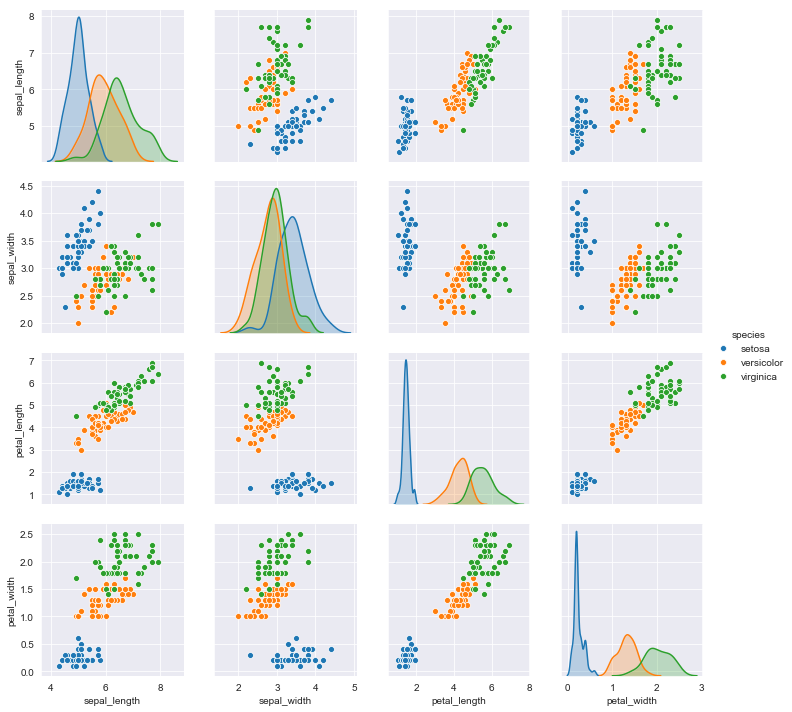

In [139]:
sns.pairplot(iris, 'species')

In [6]:
# Simplest version, 1 feature two classes
ftr = 'petal_length'
classes = ['versicolor', 'virginica']

x = iris.loc[iris.species.isin(classes), ftr]
y = iris.loc[iris.species.isin(classes), 'species']


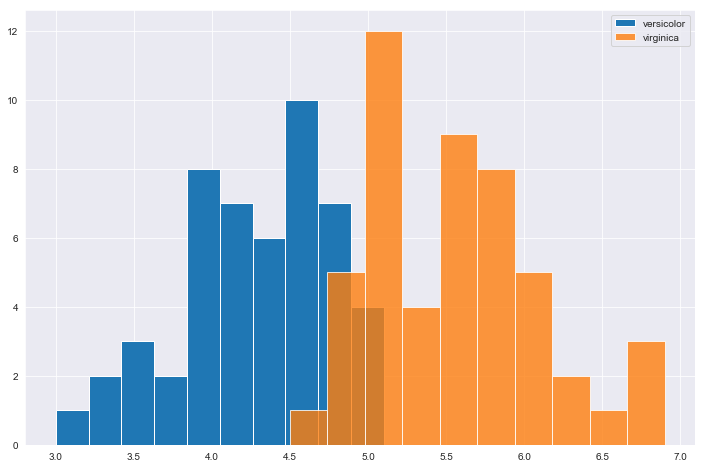

In [7]:
cls1 = x[y=='versicolor'].copy()
cls2 = x[y=='virginica'].copy()
cls1.hist(label='versicolor')
cls2.hist(alpha=0.8, label='virginica')
plt.legend()

Take the average of the means of each distribution.

In [8]:
print("Distribution of Sepal Length For {}:".format(', '.join(classes)), cls1.mean(), ', ', cls2.mean())
bd = np.mean([cls1.mean(), cls2.mean()])
print('Average of two means creates boundary decision:', bd)

Distribution of Sepal Length For versicolor, virginica: 4.26 ,  5.552
Average of two means creates boundary decision: 4.906


In [9]:
pred_cls1 = x[x<bd].index # versicolor
pred_cls2 = x[x>=bd].index # virginica

print('Accuracy for {} Preds:'.format(classes[0]), y[pred_cls1][y[pred_cls1]==classes[0]].shape[0]/y[pred_cls1].shape[0])
print('Accuracy for {} Preds:'.format(classes[1]), y[pred_cls2][y[pred_cls2]==classes[1]].shape[0]/y[pred_cls2].shape[0])



Accuracy for versicolor Preds: 0.8888888888888888
Accuracy for virginica Preds: 0.9565217391304348


To extend this to multiple features you need to assume that the ftr distributions by class are multivariate normal distributions.

For 2 features we need to find a line that best separates the two classes (the average of ftr 2 for every value of ftr1 and vice versa). For N features we need to find an N-dimensional hyperplane that best separates the classes.

In [10]:
ftr = iris.columns[2:4]
classes = ['versicolor', 'virginica']

x = iris.loc[iris.species.isin(classes), ftr]
y = iris.loc[iris.species.isin(classes), 'species']

cls1 = x[y=='versicolor'].copy()
cls2 = x[y=='virginica'].copy()


In [11]:
cls1_mean = cls1.mean() 
cls2_mean = cls2.mean()


To make a prediction you can just calculate the distance of each point to the class means and choose the mean that is closest.

In [12]:
def get_dist(input_vec, target_vec):
    return np.sqrt(sum([(x1-x0)**2 for x1,x0 in zip(input_vec,target_vec)]))

def get_preds(data, cls_mns):
    cls_dists = []
    preds = []
    for i, cls in enumerate(cls_mns):
        dists = data.apply(lambda row: get_dist(row.values, cls), axis=1).values.tolist()
        cls_dists.append(dists)
    for tup in zip(*cls_dists):
        preds.append(tup.index(min(tup)))
    return preds
        
    

In [13]:
preds = get_preds(x, [cls1_mean, cls2_mean])
# convert to labels
preds = np.asarray([classes[1] if pred else classes[0] for pred in preds])

print(
    'Accuracy For Preds:',
    (y.values == preds).sum()/len(y)
)


Accuracy For Preds: 0.94


How to find the optimal line??

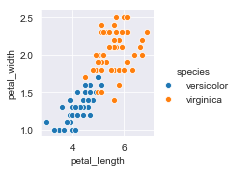

In [14]:
# you can see approx where you would draw a line to separate the classes
# how to transform??
sns.pairplot(iris[iris.species.isin(classes)], hue='species', x_vars=ftr[0], y_vars=ftr[1])

### Matrix Factorization Form

https://sebastianraschka.com/Articles/2014_python_lda.html

LDA is used to transform data into a lower dimensional space with _good class seperability_.

The full version can work on data with multiple features and multiple classes. LDA works best when features are IID Normal with equal covariance between the class distributions.

The general form of LDA is a linear transformation technique, often used for dimensionalitly reduction, that is very similar to PCA. The difference is that while PCA maximizes the variance accounted for in the components, LDA also maximizes the amount of class separation. 

There are a lot of angles to this that I don't fully understand but it looks like LDA does this by accounting for both within and between class covariance as apposed to the whole dataset (???).

___STEPS___:
    1. compute d-dimensional mean vectors (mean of each feature) for each class
    2. compute ... scatter matrices (? covariance?) for _between-class_ and _within-class_
    3. compute the eigenvectors and eigenvalues for the scatter matrices
    4. sort eigenvectors by descending eigenvalues and choose the first k eigenvectors.
        - This yields a d by k matrix where d is the number of original features and k is the number of chosen eigenvectors (each column is an eigenvector)
    5. Use this matrix as a transform on your inputs to compute a new reduced dimension subspace (n x k where n is num samples/observations)

In [136]:
ftrs = cls_mns.columns
target = 'species'
classes = iris.species.unique()

In [137]:
# 1) mean vectors

def get_means(data, ftrs, target):
    total_means = data[ftrs].mean()
    cls_mns = data.groupby(target).mean()

    return cls_mns, total_means

cls_mns, total_means = get_means(iris, ftrs, target)
cls_mns

,sepal_length,sepal_width,petal_length,petal_width
species,,,,
setosa,5.01,3.43,1.46,0.25
versicolor,5.94,2.77,4.26,1.33
virginica,6.59,2.97,5.55,2.03


In [18]:
# d1 = iris.loc[iris.species=='setosa', ftrs]
# setosa = (d1 - cls_mns.loc['setosa']).values.T.dot((d1 - cls_mns.loc['setosa']).values.T.T)

# d2 = iris.loc[iris.species=='versicolor', ftrs]
# versi = (d2 - cls_mns.loc['versicolor']).values.T.dot((d2 - cls_mns.loc['versicolor']).values.T.T)

# d3 = iris.loc[iris.species=='virginica', ftrs]
# virg = (d3 - cls_mns.loc['virginica']).values.T.dot((d3 - cls_mns.loc['virginica']).values.T.T)


In [82]:
# Scatter Matrices
def within_class(class_data, class_means=cls_mns):
    '''
    Need to reshape each to column vectors which negates the T but wrote out explicitly anyway.
    
    this is within class covariance matrix calculated as the dot product of the normalized (mean-centered)
    values. (x-m)(x-m)^T
    '''
    x = class_data[ftrs].copy()
    x_mean = class_means.loc[class_data.name]
    
    return (x-x_mean).values.T.dot((x - x_mean).values.T.T)

def between_class(class_data, total_means=total_means):
    """
    Here we look at the average difference between the means of our features for each class
    against the overall means of each ftr (for all classes).
    """
    N = class_data.shape[0]
    in_class_means = class_data.mean().values.reshape(-1,1) # make column vectors
    overall_mns = total_means.values.reshape(-1,1) # make column vectors
    inter_class_var = n*(in_class_means - overall_mns).dot((in_class_means - overall_mns).T)

    return inter_class_var

In [83]:
within_class_var = iris.groupby('species').apply(within_class).sum()
within_class_var

array([[38.9562, 13.63  , 24.6246,  5.645 ],
       [13.63  , 16.962 ,  8.1208,  4.8084],
       [24.6246,  8.1208, 27.2226,  6.2718],
       [ 5.645 ,  4.8084,  6.2718,  6.1566]])

In [84]:
between_class_var = iris.groupby('species').apply(between_class).sum()
between_class_var

array([[ 63.21213333, -19.95266667, 165.2484    ,  71.27933333],
       [-19.95266667,  11.34493333, -57.2396    , -22.93266667],
       [165.2484    , -57.2396    , 437.1028    , 186.774     ],
       [ 71.27933333, -22.93266667, 186.774     ,  80.41333333]])

In [85]:
# 3) Eigenvectors and Eigenvalues

# THIS IS THE IMPORTANT PART! 
# THE DECOMPOSITION IS ON THIS _COMBINED_ MATRIX 
# THIS COMBINED MATRIX IS THE INVERSE OF THE WITHIN CLASS COVARIANCE MULTIPLIED BY THE BETWEEN CLASS VARIANCE
combined = np.linalg.inv(within_class_var).dot(between_class_var)

eig_vals, eig_vecs = np.linalg.eig(combined)

In [86]:
eig_vals

array([ 3.21919292e+01,  2.85391043e-01,  5.69838961e-15, -5.43522649e-15])

In [111]:
eig_vecs

array([[ 0.20874182,  0.00653196, -0.87425738, -0.1249305 ],
       [ 0.38620369,  0.58661055,  0.23487074,  0.37433231],
       [-0.55401172, -0.25256154,  0.20142863,  0.44075181],
       [-0.7073504 ,  0.76945309,  0.37408057, -0.80622921]])

Eigvalues and Eigvectors satisfy the equations

$ Av_i = \lambda_i v_i $

A = $\Sigma_w^{-1} \Sigma_b$ 

v = ith eigenvector, 

lambda_i = ith eigenvalue.

In [138]:
for i in range(len(eig_vals)):
    evec = eig_vecs[:,i].reshape(-1,1)
#     print(i)
#     print(combined.dot(evec))
#     print()
#     print(eig_vals[i]*evec)
#     print('------------------')
    np.testing.assert_array_almost_equal(combined.dot(evec), eig_vals[i]*evec,)

In [118]:
# 4.a) Sort eig vals descending
sorted_idx = np.flip(np.argsort(eig_vals),0) # sort descending
sorted_eig_vals = eig_vals[sorted_idx]
sorted_eig_vecs = eig_vecs[:,sorted_idx] # columns are the vectors!

# in this case they were already sorted, but this is not guarenteed
print(sorted_eig_vals)
sorted_eig_vecs

[ 3.21919292e+01  2.85391043e-01  5.69838961e-15 -5.43522649e-15]


array([[ 0.20874182,  0.00653196, -0.87425738, -0.1249305 ],
       [ 0.38620369,  0.58661055,  0.23487074,  0.37433231],
       [-0.55401172, -0.25256154,  0.20142863,  0.44075181],
       [-0.7073504 ,  0.76945309,  0.37408057, -0.80622921]])

The explained variance is the eigenvalue divided by the sum of all the eigenvalues

In [127]:
for i,v in enumerate(sorted_eig_vals):
    print('Eigenvalue {0:} Explained Variance: {1:.2%}'.format(i, v/sorted_eig_vals.sum()))

Eigenvalue 0 Explained Variance: 99.12%
Eigenvalue 1 Explained Variance: 0.88%
Eigenvalue 2 Explained Variance: 0.00%
Eigenvalue 3 Explained Variance: -0.00%


In [128]:
# 4.b) Make our transform matrix for new dimensions
# choose two (can choose how ever many you want/think necessary) new ftr dims
W = sorted_eig_vecs[:,:2]
W

array([[ 0.20874182,  0.00653196],
       [ 0.38620369,  0.58661055],
       [-0.55401172, -0.25256154],
       [-0.7073504 ,  0.76945309]])

Note that LDA 1 maximally separates the classes

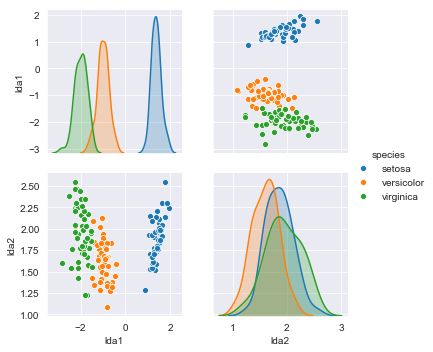

In [134]:
x_lda = iris[ftrs].dot(W)
x_lda.columns = ['lda1', 'lda2']
x_lda['species'] = iris.species
sns.pairplot(x_lda, hue='species')